# FER Transfer on FERG dataset using Norm-reference mechanism

The goal is to train the NR mechanism using BFS's Louise and applied to the different heads shapes from the FERG dataset

## import

In [1]:
import os
import numpy as np
import tensorflow as tf

from utils.load_config import load_config
from utils.load_data import load_data
from utils.extraction_model import load_extraction_model
from utils.PatternFeatureReduction import PatternFeatureSelection
from utils.ref_feature_map_neurons import ref_feature_map_neuron
from utils.calculate_position import calculate_position
from utils.patches import compute_center_of_activity

%matplotlib inline
import matplotlib.pyplot as plt

np.random.seed(0)
np.set_printoptions(precision=3, suppress=True, linewidth=150)

## Set Parameters

In [39]:
# define configuration
config_path = 'NR_06_FER_transfer_on_FERG_m0001.json'

# load config
config = load_config(config_path, path='../../configs/norm_reference')

# create directory if non existant
save_path = os.path.join("../../models/saved", config["config_name"])
if not os.path.exists(save_path):
    os.mkdir(save_path)

## Load extraction pipeline

In [3]:
# load and define extraction model
v4_model = load_extraction_model(config, input_shape=tuple(config["input_shape"]))
v4_model = tf.keras.Model(inputs=v4_model.input, outputs=v4_model.get_layer(config['v4_layer']).output)
size_ft = tuple(np.shape(v4_model.output)[1:3])
print("[LOAD] size_ft", size_ft)
print("[LOAD] Model loaded")

2022-06-15 14:45:32.479339: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-06-15 14:45:32.491905: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fde1e84b740 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-06-15 14:45:32.491920: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


[LOAD] size_ft (56, 56)
[LOAD] Model loaded


## load training data

In [4]:
# load the training data (louise)
data = load_data(config)
n_training = len(data[0])
print("[LOAD] Data loaded", np.shape(data[0]))
print()

100%|██████████| 2/2 [00:00<00:00, 68.59it/s]

[LOAD] Data loaded (2, 224, 224, 3)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


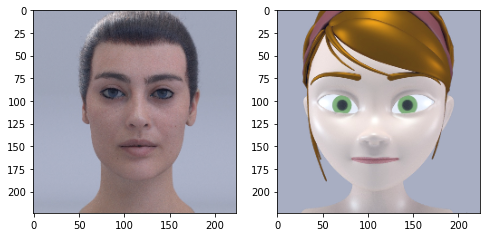

In [6]:
# plot the pre-processed images to see how the training data looks like
plt.figure(figsize=(4*n_training, 4))
for i in range(n_training):
    plt.subplot(1, n_training, i + 1)
    img = np.array(data[0][i])
    rgb_img = img[..., ::-1]
    norm_img = (rgb_img + 127.5) / 256
    plt.imshow(norm_img)

## Predict with extraction pipeline

In [7]:
# predict v4 output
preds = v4_model.predict(data[0], verbose=1)
print("[TRAIN] shape prediction", np.shape(preds))

# get feature maps that mimic a semantic selection pipeline
# keep only highest IoU semantic score
eyebrow_preds = preds[..., config['best_eyebrow_IoU_ft']]
print("shape eyebrow semantic feature selection", np.shape(eyebrow_preds))
lips_preds = preds[..., config['best_lips_IoU_ft']]
print("shape lips semantic feature selection", np.shape(lips_preds))
preds = np.concatenate((eyebrow_preds, lips_preds), axis=3)
print("[TRAIN] shape preds", np.shape(preds))

2/2 [==============================] - 0s 155ms/sample
[TRAIN] shape prediction (2, 56, 56, 256)
shape eyebrow semantic feature selection (2, 56, 56, 2)
shape lips semantic feature selection (2, 56, 56, 16)
[TRAIN] shape preds (2, 56, 56, 18)


## Train and detect facial identity (Facial Recognition)

### Build RBF templates

In [38]:
# create FR templates
fr_templates = []
rbf_fr_templates = []
fr_patterns = []

sigmas = ['louise_rbf_FR_sigma', 'merry_rbf_FR_sigma']
rbfs = ['louise_rbf_FR_pos', 'merry_rbf_FR_pos']
for i in range(n_training):
    config['rbf_sigma'] = config[sigmas[i]]
    rbf_fr_template = np.array(config[rbfs[i]])
    fr_pattern = PatternFeatureSelection(config, template=rbf_fr_template)

    # fit template
    neutral_preds = np.expand_dims(preds[i], axis=0)
    template_preds = np.repeat(np.expand_dims(neutral_preds, axis=0), len(rbf_fr_template), axis=0)
    template = fr_pattern.fit(template_preds)
    template[template < 0.25] = 0

    fr_templates.append(template[0])
    rbf_fr_templates.append(rbf_fr_template)
    fr_patterns.append(fr_pattern)

fr_templates = np.array(fr_templates)
print("[RBF FR] shape fr_templates", np.shape(fr_templates))
print("[RBF FR] Shape rbf_fr_templates", np.shape(rbf_fr_templates))

[PATTERN] Fit pattern
[PATTERN] Transform Pattern
[PATTERN] prediction transformed!
[PATTERN] Fit pattern
[PATTERN] Transform Pattern
[PATTERN] prediction transformed!
[RBF FR] shape fr_templates (2, 56, 56, 3)
[RBF FR] Shape rbf_fr_templates (2, 3, 2, 2)


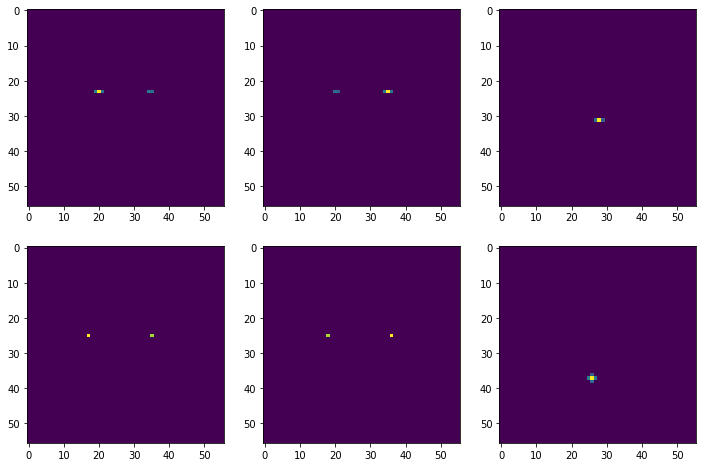

In [12]:
# show templates
n_templates = np.shape(fr_templates)[-1]

plt.figure(figsize=(n_templates * 4, n_training * 4))
for i in range(n_training):
    for j in range(n_templates):
        plt.subplot(n_training, n_templates, i * n_templates + j + 1)
        plt.imshow(fr_templates[i, ..., j])

### patch images (Transformers trick)

In [13]:
# split in patches
def pred_to_patch(pred, patch_size=8):
    pred = np.expand_dims(pred, axis=[0, 3])
    patches = tf.image.extract_patches(
        images=pred,
        sizes=[1, patch_size, patch_size, 1],
        strides=[1, patch_size, patch_size, 1],
        rates=[1, 1, 1, 1],
        padding="VALID",
    )
    patches = patches.numpy()
    return patches

In [14]:
def get_patches_centers(patches, patch_size=8, verbose=False):
    # compute center of activity for each patch
    centers = []
    max_patch = []
    for i in range(np.shape(patches)[1]):
        for j in range(np.shape(patches)[2]):
            # control if patches is not all zeros
            f_patch = patches[0, i, j]
            if np.sum(f_patch) > 0:
                CoA = compute_center_of_activity(np.reshape(f_patch, [patch_size, patch_size]), verbose=verbose)
                # compensate with patch positions
                centers.append([CoA[0] + j*patch_size, CoA[1] + i*patch_size])

                # keep maximum activity of the patch
                max_patch.append(np.amax(f_patch))

    return centers, max_patch

In [15]:
def get_activity_from_patterns(preds, patterns, rbf_templates, threshold_val=0.25, do_plot=False):
    templates = []
    for p, pattern in enumerate(patterns):
        _preds = np.expand_dims(preds, axis=0)
        _preds = np.repeat(np.expand_dims(_preds, axis=0), len(rbf_templates[p]), axis=0)
        template = pattern.transform(_preds)
        template[template < threshold_val] = 0
        templates.append(template)

        if do_plot:
            n_templates = np.shape(template)[-1]
            plt.figure(figsize=(n_templates * 4, 4))
            for i in range(n_templates):
                plt.subplot(1, n_templates, i+1)
                plt.imshow(template[0, ..., i], cmap='Greys')
                plt.title("Activity template {}".format(i))

    # concatenate all templates
    _templates = np.array(templates[0])
    for i in range(1, len(patterns)):
        _templates = np.concatenate((_templates, templates[i]), axis=3)

    # get pos for each type
    pos_dict = {}
    n_entry = 0
    for i in range(np.shape(_templates)[-1]):
        patches = pred_to_patch(_templates[0, ..., i])
        positions, max_values = get_patches_centers(patches)

        for pos, max_val in zip(positions, max_values):
            pos_dict[n_entry] = {'type': i, 'pos': pos, 'max': max_val}
            n_entry += 1

    return pos_dict

In [25]:
fr_lmks = []
for i in range(n_training):
    fr_lmk = get_activity_from_patterns(preds[i], fr_patterns, rbf_fr_templates)
    fr_lmks.append(fr_lmk)

    for j in range(len(fr_lmk)):
        print("[RF LMK] {}) fr_lmk: {}".format(j, fr_lmk[j]))
    print()

[PATTERN] Transform Pattern
[PATTERN] prediction transformed!
[PATTERN] Transform Pattern
[PATTERN] prediction transformed!
[RF LMK] 0) fr_lmk: {'type': 0, 'pos': [19.966002766151703, 22.999975340016615], 'max': 1.0}
[RF LMK] 1) fr_lmk: {'type': 0, 'pos': [34.47542658327545, 22.999941827169152], 'max': 0.4039647341998409}
[RF LMK] 2) fr_lmk: {'type': 1, 'pos': [20.456198774328566, 22.999933469041206], 'max': 0.36614782593032746}
[RF LMK] 3) fr_lmk: {'type': 1, 'pos': [34.98646352255619, 22.99997527961495], 'max': 1.0}
[RF LMK] 4) fr_lmk: {'type': 2, 'pos': [27.955234898578958, 30.99997265928053], 'max': 1.0}

[PATTERN] Transform Pattern
[PATTERN] prediction transformed!
[PATTERN] Transform Pattern
[PATTERN] prediction transformed!
[RF LMK] 0) fr_lmk: {'type': 3, 'pos': [16.99999360004096, 24.99999360004096], 'max': 1.0}
[RF LMK] 1) fr_lmk: {'type': 3, 'pos': [34.999977561079135, 24.99999252035971], 'max': 0.8556497216827943}
[RF LMK] 2) fr_lmk: {'type': 4, 'pos': [17.999985342902725, 2

### Get identity (Max pooling)

In [26]:
def max_pool_activity(activity_dict, dist_threshold=3, sorting='max', verbose=False):
    filt_dictionary = {}
    discarded_primer_idx = []

    for p_t in range(len(activity_dict)):
        for p_a in range(p_t + 1, len(activity_dict)):  # only upward diagonal
            # get primers
            p_target = activity_dict[p_t]
            p_agent = activity_dict[p_a]

            # retrieve positions
            pos_target = np.array(p_target["pos"])
            pos_agent = np.array(p_agent["pos"])
            distance = np.linalg.norm(pos_target - pos_agent)

            if verbose:
                print("distance", distance)

            # sort if distance is smaller than the threshold
            if distance < dist_threshold:
                # todo add possibility to sort by clustering the mean
                if sorting == 'max':
                    if p_target["max"] > p_agent["max"]:
                        discarded_primer_idx.append(p_a)
                    else:
                        discarded_primer_idx.append(p_t)

    if verbose:
        print("discarded primers")
        print(discarded_primer_idx)

    # append all non discarded primers
    n_primer = 0
    for p in activity_dict:
        if p not in discarded_primer_idx:
            primer = activity_dict[p]
            filt_dictionary[n_primer] = {"type": primer["type"], "pos": primer["pos"], "max": primer["max"]}
            n_primer += 1

    return filt_dictionary

In [27]:
def get_type(activity_dict, verbose=False):
    type_counters = [0, 0, 0]  # hum_type, monk_type, cart_type
    positions = []

    for i in activity_dict:
        if verbose:
            print(activity_dict[i])
        dict = activity_dict[i]

        # count types
        if dict['type'] in [0, 1, 2]:
            type_counters[0] += 1
        elif dict['type'] in [3, 4, 5]:
            type_counters[1] += 1
        elif dict['type'] in [6, 7, 8]:
            type_counters[2] += 1

        # get positions of types
        if dict['type'] in [0, 3, 6]:
            right_eye_pos = dict['pos']
        elif dict['type'] in [1, 4, 7]:
            left_eye_pos = dict['pos']
        elif dict['type'] in [2, 5, 8]:
            nose_pos = dict['pos']

        positions.append(dict['pos'])

    if verbose:
        print("types:", type_counters)
        print("positions")
        print(positions)
        print()

    bfs_type = np.argmax(type_counters)
    mean_pos = np.mean(positions, axis=0)
    width = left_eye_pos[0] - right_eye_pos[0]
    height = nose_pos[1] - np.amin([left_eye_pos[1], right_eye_pos[1]])

    return bfs_type, mean_pos, [width, height]

In [28]:
fr_lmks_pooled = []
fr_types = []
fr_faces_pos = []
fr_faces_size = []
for i in range(n_training):
    fr_lmk_pooled = max_pool_activity(fr_lmks[i])
    fr_lmks_pooled.append(fr_lmk_pooled)
    fr_type, face_pos, face_size = get_type(fr_lmk_pooled)
    fr_types.append(fr_type)
    fr_faces_pos.append(face_pos)
    fr_faces_size.append(face_size)

    print("[FR] len fr_lmk_pooled", len(fr_lmk_pooled))
    print("[FR] type:", fr_type)
    print("[FR] face_pos:", face_pos)
    print("[FR] face_size:", face_size)
    print()

[FR] len fr_lmk_pooled 3
[FR] type: 0
[FR] face_pos: [27.636 25.667]
[FR] face_size: [15.02046075640449, 7.9999973796655794]

[FR] len fr_lmk_pooled 3
[FR] type: 1
[FR] face_pos: [26.331 29.009]
[FR] face_size: [18.999980800122877, 12.027388503045337]



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


min max 0.057503906250000014 0.987578125
min max 0.03835937499999997 1.0881289062500001


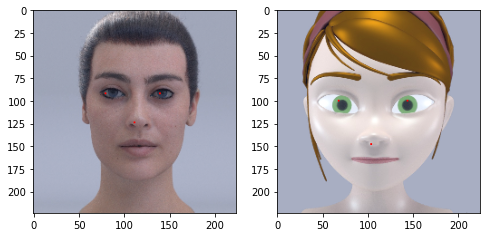

In [32]:
# display FR lmks on training img
img_to_ft_ratio = 224 / 56

plt.figure(figsize=(4 * n_training, 4))
for i in range(n_training):
    plt.subplot(1, n_training, i + 1)
    img = np.array(data[0][i])
    img = img[..., ::-1]
    img = (np.array(img) + 127.5) / 256

    fr_lmk_pooled = fr_lmks_pooled[i]
    n_fr_lmk = len(fr_lmk_pooled)
    for j in range(n_fr_lmk):
        lmk_pos = np.array(fr_lmk_pooled[j]['pos']) * img_to_ft_ratio
        pos_x = int(round(lmk_pos[0]))
        pos_y = int(round(lmk_pos[1]))
        img[(pos_y-1):(pos_y+1), (pos_x-1):(pos_x+1)] = [1, 0, 0]

    plt.imshow(img)
    # plt.imsave("test_0.jpg", img)

## FER recognition

## get FER lmks

In [41]:
# create FER templates
fer_templates = []
rbf_fer_templates = []
fer_patterns = []

ref_sigmas = ['louise_rbf_FER_sigma', 'merry_rbf_FER_sigma']
ref_rbfs = ['louise_rbf_FER_pos', 'merry_rbf_FER_pos']
ref_rbfs_mask = ['louise_rbf_FER_mask', 'merry_rbf_FER_mask']
ref_rbfs_zeros = ['louise_rbf_FER_zeros', 'merry_rbf_FER_zeros']

for i in range(n_training):
    config['rbf_sigma'] = config[ref_sigmas[i]]
    rbf_fer_template = np.array(config[ref_rbfs[i]])
    ref_rbf_mask = np.array(config[ref_rbfs_mask[i]])
    ref_rbf_zeros = config[ref_rbfs_zeros[i]]
    fer_pattern = PatternFeatureSelection(config, template=rbf_fer_template, mask=ref_rbf_mask, zeros=ref_rbf_zeros)

    # fit template
    neutral_preds = np.expand_dims(preds[i], axis=0)
    template_preds = np.repeat(np.expand_dims(neutral_preds, axis=0), len(rbf_fer_template), axis=0)
    template = fer_pattern.fit(template_preds)
    template[template < 0.25] = 0

    fer_templates.append(template[0])
    rbf_fer_templates.append(rbf_fer_template)
    fer_patterns.append(fer_pattern)
    print()

fr_templates = np.array(fr_templates)
print("[RBF FER] shape fr_templates", np.shape(fr_templates))
print("[RBF FER] Shape rbf_fr_templates", np.shape(rbf_fr_templates))

[PATTERN] Fit pattern
[PATTERN] fit pattern: use mask ON
[PATTERN] apply mask - shape preds (10, 1, 56, 56, 18)
[PATTERN] fit pattern: use zeros ON
[PATTERN] apply zeros - shape preds (10, 1, 56, 56, 18)
[PATTERN] Transform Pattern
[PATTERN] prediction transformed!

[PATTERN] Fit pattern
[PATTERN] fit pattern: use mask ON
[PATTERN] apply mask - shape preds (10, 1, 56, 56, 18)
[PATTERN] fit pattern: use zeros ON
[PATTERN] apply zeros - shape preds (10, 1, 56, 56, 18)
[PATTERN] Transform Pattern
[PATTERN] prediction transformed!

[RBF FER] shape fr_templates (2, 56, 56, 3)
[RBF FER] Shape rbf_fr_templates (2, 3, 2, 2)
